In [2]:
from mediadata import(
    get_headline_df,
    get_biden_trump_dataframes
)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import datetime
import numpy as np
import pandas as pd

In [3]:
start_date = datetime.date(2024, 3, 1)
end_date = datetime.date(2024, 4, 1)

cnn_headlines = []
fox_headlines = []

def get_headlines_over_dates(media_org: str, start: datetime.date, end: datetime.date):
    headlines = []
    current_date = start_date
    while current_date < end_date:

        try:
            headlines.append(get_headline_df(media_org, current_date))
        except: 
            pass

        current_date += datetime.timedelta(1)
        
    if len(headlines) == 0:
        return pd.DataFrame()
    return pd.concat(headlines)
    

In [7]:
current_date = start_date
while current_date < end_date:
    
    try:
        fox_headlines.append(get_headline_df('FOX', current_date))
    except: 
        pass
    
    current_date += datetime.timedelta(1)

In [71]:
all_fox = get_headlines_over_dates('FOX', start_date, end_date)
all_cnn = get_headlines_over_dates('CNN', start_date, end_date)
all_abc = get_headlines_over_dates('abc', start_date, end_date)
all_daily = get_headlines_over_dates('daily', start_date, end_date)
all_nbc = get_headlines_over_dates('nbc', start_date, end_date)
all_nypost = get_headlines_over_dates('nypost', start_date, end_date)
all_skyus = get_headlines_over_dates('skyus', start_date, end_date)
all_smh = get_headlines_over_dates('smh', start_date, end_date)

In [72]:
total = pd.concat([all_fox, all_cnn, all_abc, all_daily, all_nbc, all_nypost, all_skyus, all_smh])
len(total)

28706

In [79]:
biden, trump, both, neither = get_biden_trump_dataframes(total)
both = both[['Headline']]

# filter out super tuesday biases
both['Headline'] = both['Headline'].apply(lambda x: x.lower().replace('super', ''))

In [80]:
both['Compound'] = both['Headline'].apply(lambda x: SIA.polarity_scores(x)['compound'])
both_sorted = both.sort_values('Compound')
negative_sample = both_sorted[both_sorted['Compound'] < -0.4]
positive_sample = both_sorted[both_sorted['Compound'] > 0.4]

In [81]:
len(negative_sample)

37

In [82]:
len(positive_sample)

37

In [83]:
negative_sample.to_csv('negative_political_training_data.csv', index=False, encoding='UTF8')
positive_sample.to_csv('positive_political_training_data.csv', index=False, encoding='UTF8')

In [84]:
SIA = SentimentIntensityAnalyzer()

In [22]:
combined['Compound'] = combined['Headline'].apply(lambda x: SIA.polarity_scores(x)['compound'])

In [26]:
sorted_df = combined.sort_values('Compound')

In [34]:
negative_sample = sorted_df[sorted_df['Compound'] < -0.8]
positive_sample = sorted_df[sorted_df['Compound'] > 0.8]

In [35]:
len(negative_sample)

425

In [36]:
len(positive_sample)

89

In [42]:
negative_sample.to_csv('negative_training_data.csv', index=False, encoding='UTF8')
positive_sample.to_csv('positive_training_data.csv', index=False, encoding='UTF8')

In [44]:
both

,Headline,contains_biden,contains_trump,contains_both
86,"Super Tuesday may set Biden, Trump rematch, Sp...",True,True,True
119,Trump leads Biden among voters who favored Bid...,True,True,True
156,"Super Tuesday results expected to move Biden, ...",True,True,True
166,Super Tuesday results expected to propel Trump...,True,True,True
249,Trump leads Biden among voters who favored Bid...,True,True,True
...,...,...,...,...
45,Supreme Court escalates high-stakes border dra...,True,True,True
69,"Biden’s cash edge widens, Trump’s lawyer fees ...",True,True,True
37,Supreme Court escalates high-stakes border dra...,True,True,True
32,Supreme Court escalates high-stakes border dra...,True,True,True


In [46]:
p

,Headline
86,"Super Tuesday may set Biden, Trump rematch, Sp..."
119,Trump leads Biden among voters who favored Bid...
156,"Super Tuesday results expected to move Biden, ..."
166,Super Tuesday results expected to propel Trump...
249,Trump leads Biden among voters who favored Bid...
...,...
45,Supreme Court escalates high-stakes border dra...
69,"Biden’s cash edge widens, Trump’s lawyer fees ..."
37,Supreme Court escalates high-stakes border dra...
32,Supreme Court escalates high-stakes border dra...


In [4]:
filtered_negative = pd.read_csv('negative_political_training_data.csv').dropna()
filtered_positive = pd.read_csv('positive_political_training_data.csv').dropna()

In [6]:
from mediadata import embed_data


In [7]:
embedded_negative= embed_data(filtered_negative)
embedded_positive= embed_data(filtered_positive)
negative_center = embedded_negative.mean(axis=0)
positive_center = embedded_positive.mean(axis=0)

In [138]:
positive_center

0     -0.003074
1      0.006880
2      0.069811
3      0.001583
4      0.010875
         ...   
379    0.025620
380    0.015569
381   -0.016042
382   -0.038823
383    0.062362
Length: 384, dtype: float32

In [8]:
from sklearn.metrics.pairwise import cosine_similarity


In [103]:
import numpy as np
np_neg_center = np.array(negative_center)
np_pos_center = np.array(positive_center)

In [114]:
pd.DataFrame(np_neg_center).T.to_csv('negative_center.csv', index=False)

In [113]:
pd.DataFrame(np_pos_center).T.to_csv('positive_center.csv', index=False)

In [15]:
from sentence_transformers import SentenceTransformer 
from mediadata import embed_data, embed_point

def get_absolute_polarisation(media_org: str,
                               date: datetime.date,
                               positive_center,
                               negative_center) -> float:
    """Gets the cosine similarity between all biden articles and all trump articles for a given day."""
    df = get_headline_df(media_org, date)
    only_biden, only_trump, _, _ = get_biden_trump_dataframes(df)

    # aggregate all the headlines into one string (each headline separated by a fullstop)
    aggregated_biden = '. '.join(only_biden['Headline'])
    aggregated_trump = '. '.join(only_trump['Headline'])
    
    # embed resultant headlines in the model
    model = SentenceTransformer('all-MiniLM-L6-v2')
    biden_encoded = embed_point(aggregated_biden, model)
    trump_encoded = embed_point(aggregated_trump, model)
    
    # determine cosine similarity - 2D array output
#     biden_positive_sentiment = cosine_similarity([biden_encoded], [positive_center])[0][0]
#     biden_negative_sentiment = cosine_similarity([biden_encoded], [negative_center])[0][0]

    
#     trump_positive_sentiment = cosine_similarity([trump_encoded], [positive_center])[0][0]
#     trump_negative_sentiment = cosine_similarity([trump_encoded], [negative_center])[0][0]

    d2 = np.linalg.norm(biden_encoded - negative_center)
    d1 = np.linalg.norm(biden_encoded - positive_center)
    
#     print(f"Distances for biden are {d2} {d1}", end = ' ')
    net_biden = d2 - d1
    
    d2 = np.linalg.norm(trump_encoded - negative_center)
    d1 = np.linalg.norm(trump_encoded - positive_center)
    net_trump = d2 - d1
#     print(f"Distances for Trump are {d2} {d1}")
    
    return net_biden, net_trump


def get_polarisations(media_org, start_date, end_date, positive_center, negative_center):
    
    biden_sentiments = []
    trump_sentiments = []
    dates = []
    
    current_date = start_date
    while current_date < end_date:
        try:
            biden, trump = get_absolute_polarisation(media_org, current_date, positive_center, negative_center)
            biden_sentiments.append(biden)
            trump_sentiments.append(trump)
            dates.append(current_date)
        except KeyError:
            pass
        current_date += datetime.timedelta(1)
    
    return pd.DataFrame({f'{media_org}_Biden': biden_sentiments, f'{media_org}_Trump': trump_sentiments, 'Dates': dates})

cnn_data = get_polarisations('CNN', start_date, end_date, positive_center, negative_center)

In [18]:
fox_data = get_polarisations('FOX', start_date, end_date, positive_center, negative_center)

In [ ]:
cnn_data = cnn_data.set_index('Dates')
fox_data = fox_data.set_index('Dates')


In [36]:

cnn_data.index = pd.to_datetime(cnn_data.index)
fox_data.index = pd.to_datetime(fox_data.index)

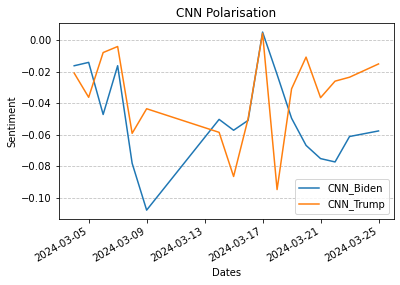

In [58]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
cnn_data[[i for i in cnn_data.columns if 'CNN' in i]].plot(ax=ax)
ax.set_ylabel('Sentiment')
ax.set_title('CNN Polarisation')
ax.set_facecolor("#ffffff")
ax.grid(axis="y", which="major", color="#666666", linestyle='--', alpha=0.4)
plt.savefig('CNN_absolute.png')

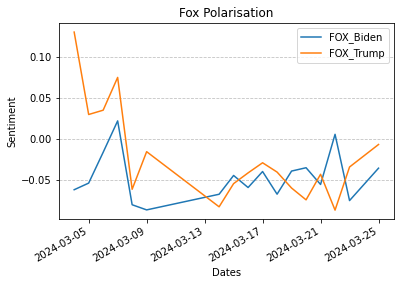

In [57]:
fig, ax = plt.subplots()
fox_data.plot(ax=ax)
ax.set_ylabel('Sentiment')
ax.set_title('Fox Polarisation')
ax.set_facecolor("#ffffff")
ax.grid(axis="y", which="major", color="#666666", linestyle='--', alpha=0.4)
plt.savefig('Fox_Absolute.png')

In [56]:
combined = cnn_data
combined['FOX_BIDEN'] = fox_data['FOX_Biden']
combined['FOX_Trump'] = fox_data['FOX_Trump']

In [47]:
cnn_data

,CNN_Biden,CNN_Trump,FOX_BIDEN,FOX_Trump
Dates,,,,
2024-03-04,-0.016095,-0.020765,-0.061814,0.131023
2024-03-05,-0.013952,-0.036170,-0.053707,0.030202
2024-03-06,-0.047097,-0.007692,-0.016043,0.035472
2024-03-07,-0.016071,-0.003855,0.022391,0.075568
2024-03-08,-0.078148,-0.059099,-0.080188,-0.061256
2024-03-09,-0.107946,-0.043451,-0.086482,-0.015271
2024-03-14,-0.050224,-0.058463,-0.067346,-0.082695
2024-03-15,-0.057131,-0.086546,-0.044367,-0.054355
2024-03-16,-0.050868,-0.049840,-0.059113,-0.041207


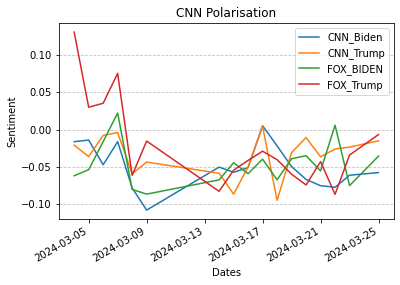

In [50]:
fig, ax = plt.subplots()
cnn_data.plot(ax=ax)
ax.set_ylabel('Sentiment')
ax.set_title('CNN Polarisation')
ax.set_facecolor("#ffffff")
ax.grid(axis="y", which="major", color="#666666", linestyle='--', alpha=0.4)
plt.savefig('Absolute_values.png')

In [34]:
pd.to_datetime(fox_data.index)

DatetimeIndex(['2024-03-04', '2024-03-05', '2024-03-06', '2024-03-07',
               '2024-03-08', '2024-03-09', '2024-03-14', '2024-03-15',
               '2024-03-16', '2024-03-17', '2024-03-18', '2024-03-19',
               '2024-03-20', '2024-03-21', '2024-03-22', '2024-03-23',
               '2024-03-25'],
              dtype='datetime64[ns]', name='Dates', freq=None)